<a href="https://colab.research.google.com/github/EnoiuDiana/Stroke-Predictor/blob/bori_dev/Stroke_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stroke Prediction based on medical and demographical data

## Problem Statement

TODO: nice description of what we want to do, why this is relevant, etc.

## Dataset



*   [source](https://https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)
*   each entry represents one person
*   label, to be predicted: whether a person is likely to have a stroke



## Setup

In [2]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
file_path = "https://drive.google.com/file/d/1x3Vu2Egi5LIvd0jkHnZKeBx-Ye0l8sTr/view?usp=sharing"
file_path ='https://drive.google.com/uc?id=' + file_path.split('/')[-2]
stroke_df = pd.read_csv(file_path)

In [4]:
stroke_df = stroke_df.rename(str.lower, axis='columns')
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
def_plot_length = 7
def_fig_size = (def_plot_length, def_plot_length)
def_title_size = 20

## Initial Data Analysis

Goal: 
*   get to know our data
*   see how data should be cleaned
*   find interesting correlations
*   formulate a hypothesis

TODO: write a nice introduction before submitting the assignment :)

In [6]:
stroke_df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


### Analysing the individual features

#### Helper functions

In [43]:
def plot_continuous_variable_distribution(df, var_series, var_name, title):
  sns.displot(data=df, x=var_name, kde=True, height=def_plot_length)
  # median
  disp = 0.4
  plt.axvline(x=var_series.median(),
              color='red')
  plt.text(var_series.median() + disp, 0, "50%", rotation = 90)
  # 25%
  plt.axvline(x=var_series.quantile(0.25),
              color='red')
  plt.text(var_series.quantile(0.25) + disp, 0, "25%", rotation = 90)
  # 75%
  plt.axvline(x=var_series.quantile(0.75),
              color='red')
  plt.text(var_series.quantile(0.75) + disp, 0, "75%", rotation = 90)
  # mean
  plt.axvline(x=var_series.mean(),
              color='green')
  plt.text(var_series.mean() + disp, 0, "Mean", rotation = 90)

  plt.title(title, size=def_title_size)

In [22]:
def plot_continuous_variable_stroke_ratio(df, var_name, no_quantiles, title, xticks_rotation=0):
  stroke_df_group = stroke_df.copy()
  stroke_df_group[var_name+"_group"] = pd.qcut(stroke_df_group[var_name], q=no_quantiles)
  stroke_ratio_per_var_group = stroke_df_group.groupby([var_name+"_group"]).apply(lambda age_group: age_group["stroke"].sum() / age_group["stroke"].count())
  fig, ax = plt.subplots(figsize=def_fig_size)
  pal = sns.color_palette("rocket", len(stroke_ratio_per_var_group))
  rank = stroke_ratio_per_var_group.argsort().argsort()   # http://stackoverflow.com/a/6266510/1628638
  plots = sns.barplot(x = stroke_ratio_per_var_group.index, y = stroke_ratio_per_var_group.values, ax = ax, palette = np.array(pal[::-1])[rank])

  # Iterrating over the bars one-by-one to add annotations
  for bar in plots.patches:
      plots.annotate(format(bar.get_height(), '.2f'),
                    (bar.get_x() + bar.get_width() / 2,
                      bar.get_height()), ha='center', va='center',
                    size=8, xytext=(0, 8),
                    textcoords='offset points')
      
  plt.xticks(rotation=xticks_rotation)
  plt.title(title, size = def_title_size)


In [130]:
def plot_categorical_variable_stroke_ratio(df, var_name, title, nr_decimals=2):
  stroke_cnt = df.groupby([var_name, 'stroke']).count()
  stroke_cnt = stroke_cnt.loc[:, :, ] .reset_index().pivot(index=var_name, columns='stroke', values='id')
  stroke_cnt['stroke_ratio'] = stroke_cnt[1] / (stroke_cnt[0] + stroke_cnt[1])

  fig, ax = plt.subplots(figsize=(10, 6))
  pal = sns.color_palette("rocket", len(stroke_cnt))
  rank = stroke_cnt['stroke_ratio'].argsort().argsort()   # http://stackoverflow.com/a/6266510/1628638
  plots = sns.barplot(x = stroke_cnt.index, y = stroke_cnt['stroke_ratio'], ax = ax, palette = np.array(pal[::-1])[rank])

  # Iterrating over the bars one-by-one to add annotations
  for bar in plots.patches:
      plots.annotate(format(bar.get_height(), '.{0}f'.format(nr_decimals)),
                    (bar.get_x() + bar.get_width() / 2,
                      bar.get_height()), ha='center', va='center',
                    size=15, xytext=(0, 8),
                    textcoords='offset points')

  plt.title(title, size = def_title_size)

In [132]:
def identify_bmi_cathegory(bmi):
  if(bmi >= 0.0 and bmi < 18.5):
    return 'underweight'
  if(bmi >= 18.5 and bmi < 25.0):
    return 'normal'
  if(bmi >= 25.0 and bmi < 30.0):
    return 'overweight'
  if(bmi >= 30.0 and bmi < 35.0):
    return 'moderate obesity'
  if(bmi >= 35.0 and bmi < 40.0):
    return 'severe obesity'
  if(bmi >= 40.0 and bmi < 100.0):
    return 'very severe obesity'

#### Gender

First of all, we should analyze the gender types that we have in our dataset.

In [109]:
gender_value_counts = stroke_df.gender.value_counts()
gender_value_counts

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

We only have one value for other gender type, it might not help us with our prediction.

In [110]:
stroke_df.loc[stroke_df['gender']=='Other']


,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


Having a pie chart will help us visualize better the ratio between females and males. We can observe that this ratio is not very balanced, having 59% females and only 41% male.

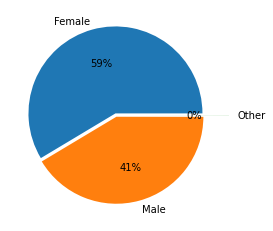

In [111]:
explode = [0.02,0.02,0.3]
plt.pie(gender_value_counts.array, labels=gender_value_counts.index, autopct = '%0.0f%%', explode = explode)
plt.show()

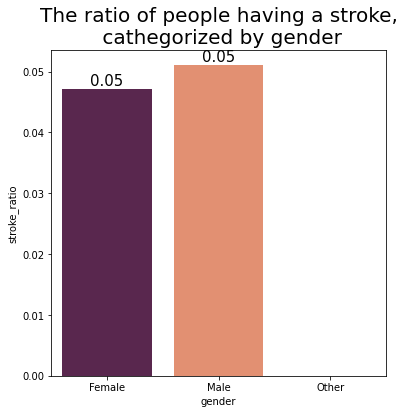

In [112]:
plot_categorical_variable_stroke_ratio(stroke_df, "gender", "The ratio of people having a stroke,\n cathegorized by gender")

The stroke events are evenly split among men and woman, but the number of men that had stroke is slightly greater than the number of woman, in our dataset. In general it is expected that stroke events are more frequently in woman, as they tend to live longer ([see article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2665267/)).

#### Age

In [113]:
stroke_df.age.describe()

count    5110.000000
mean       43.226614
std        22.612647
min         0.080000
25%        25.000000
50%        45.000000
75%        61.000000
max        82.000000
Name: age, dtype: float64



*   **median age: 45.0**
  *   considering that the **median age in the world is only 30.63**, this dataset seems to describe an **aging population**, probably from one of the highly developed countries
  *   note that only 5 countries in he world have a median age >= 5 (Italy, Saint Pierre and Miquelon, Germany, Japan and Monaco)
  *   source: [worldpopulationreview.com](https://worldpopulationreview.com/country-rankings/median-age)



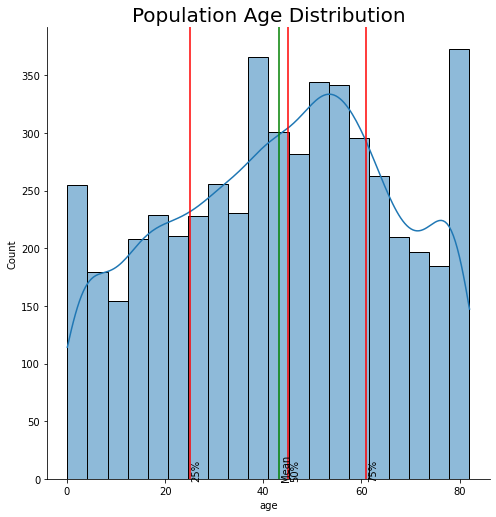

In [114]:
plot_continuous_variable_distribution(stroke_df, stroke_df.age, "age", "Population Age Distribution")

Text(0.5, 1.0, 'Age Distribution by Stroke Status')

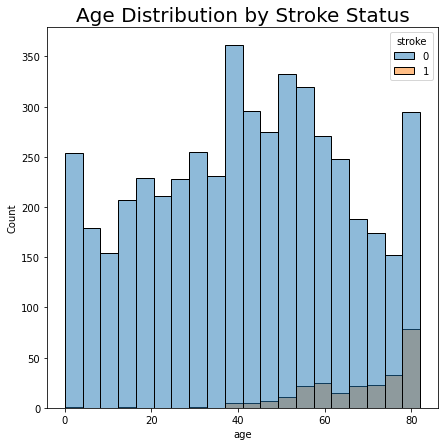

In [115]:
fig, ax = plt.subplots(figsize=def_fig_size)
sns.histplot(data=stroke_df, x="age", hue="stroke", ax=ax)
plt.title("Age Distribution by Stroke Status", size = def_title_size)

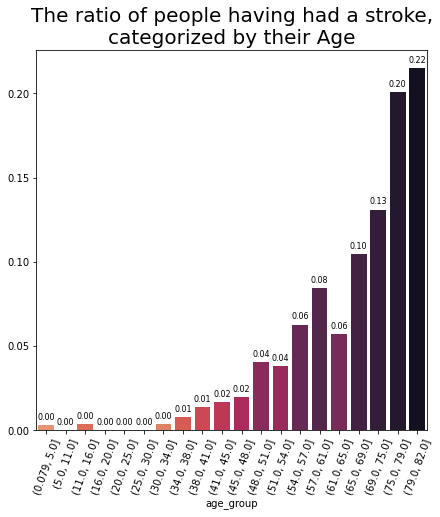

In [134]:
plot_continuous_variable_stroke_ratio(stroke_df, "age", 20, "The ratio of people having had a stroke,\ncategorized by their Age", 70)

As expected, the ratio of the population who had a stroke increases by age.

#### Hypertension

From all the persons in our dataset, we can see that only 10% have had hypertension. Globally, **an estimated 26% of the world’s population** (972 million people) has hypertension.

https://www.medscape.com/answers/241381-7614/what-is-the-global-prevalence-of-hypertension-high-blood-pressure

In [117]:
hypertension_value_counts = stroke_df.hypertension.value_counts()
hypertension_value_counts

0    4612
1     498
Name: hypertension, dtype: int64

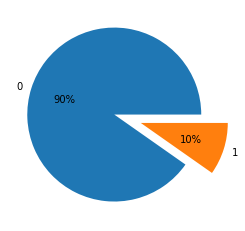

In [118]:
explode = [0.02,0.3]
plt.pie(hypertension_value_counts.array, labels=hypertension_value_counts.index, autopct = '%0.0f%%', explode = explode)
plt.show()

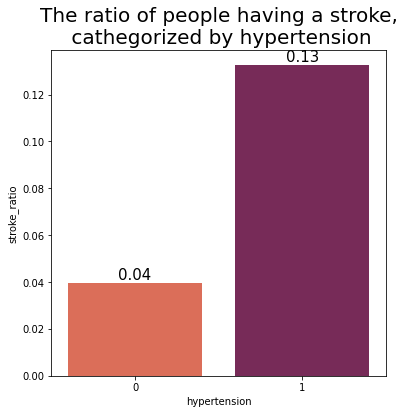

In [119]:
plot_categorical_variable_stroke_ratio(stroke_df, "hypertension", "The ratio of people having a stroke,\n cathegorized by hypertension")

As expected, a stroke is more common for people that suffer from hypertension than the rest of the people.

#### Heart Disease

The feeature shows whether a person has (1) os hasn't got (0) any herat diseases.

In [120]:
heart_disease_value_counts = stroke_df.heart_disease.value_counts()
heart_disease_value_counts

0    4834
1     276
Name: heart_disease, dtype: int64

Only 276 people out of 5110 had a heart disease.

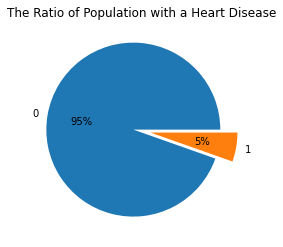

In [121]:
explode = [0.1] * heart_disease_value_counts.count()
plt.pie(heart_disease_value_counts.array, labels=heart_disease_value_counts.index, autopct = '%0.0f%%', explode = explode)
plt.title("The Ratio of Population with a Heart Disease")
plt.show()

The people with a heart disease represent 5% of the population.

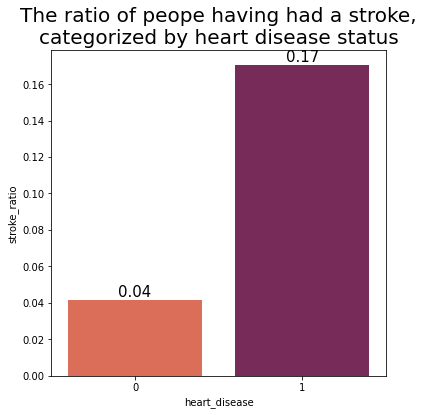

In [122]:
plot_categorical_variable_stroke_ratio(stroke_df, "heart_disease", "The ratio of peope having had a stroke,\ncategorized by heart disease status")

As expected, the ratio of people who had a stroke is much higher (17% vs 4%) among people with a heart disease.

#### Marital Status

The values for marital status are 'Yes' or 'No' values. We prefer to have 0 or 1 values instead.

In [12]:
ever_married_value_counts = stroke_df.ever_married.value_counts()
ever_married_value_counts

Yes    3353
No     1757
Name: ever_married, dtype: int64

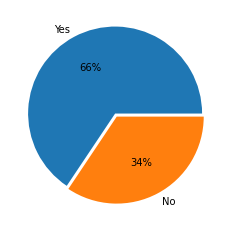

In [13]:
explode = [0.02,0.02]
plt.pie(ever_married_value_counts.array, labels=ever_married_value_counts.index, autopct = '%0.0f%%', explode = explode)
plt.show()

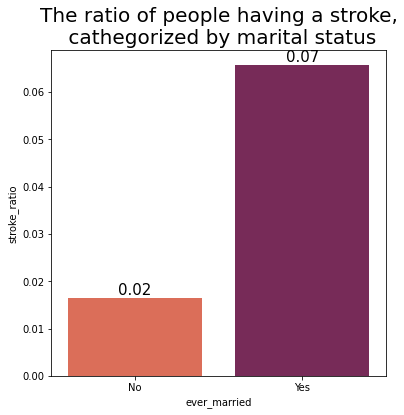

In [26]:
plot_categorical_variable_stroke_ratio(stroke_df, "ever_married", "The ratio of people having a stroke,\n cathegorized by marital status")

This plot shows that stroke is more common in people who are married, but that is due to the fact that older people (that are at a higher risk of having a stroke) in general are married. 

#### Work Type

We have identified several work types i.e. private, self-employed, government job, children and never worked.

In [123]:
work_type_value_counts = stroke_df.work_type.value_counts()
work_type_value_counts

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

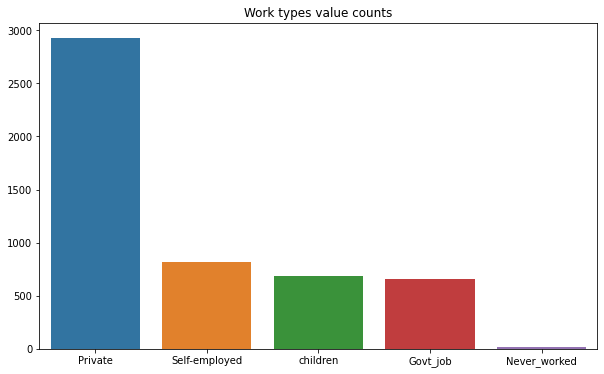

In [124]:
plt.figure(figsize=(10,6))
plt.title("Work types value counts")
sns.barplot(x=work_type_value_counts.index, y=work_type_value_counts.array)
plt.show()

The values children and never worked might be corellated since most children don't work. Let's see how many never worked values are for people with an age greater than 18.

In [125]:
stroke_df.loc[(stroke_df['work_type'] == 'Never_worked') & (stroke_df['age'] >= 18)]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
603,61408,Male,23.0,0,0,No,Never_worked,Urban,125.26,18.7,never smoked,0
886,13948,Female,19.0,0,0,No,Never_worked,Urban,86.96,25.8,never smoked,0
2917,11702,Female,18.0,0,0,No,Never_worked,Urban,82.36,22.7,Unknown,0
4160,71966,Female,18.0,0,0,No,Never_worked,Urban,81.73,21.6,never smoked,0
4772,13960,Female,18.0,0,0,No,Never_worked,Urban,97.65,21.5,Unknown,0


There are only five values for never worked people that aren't children. They also didn't have a stroke. We might consider deleting them in the data cleaning process.

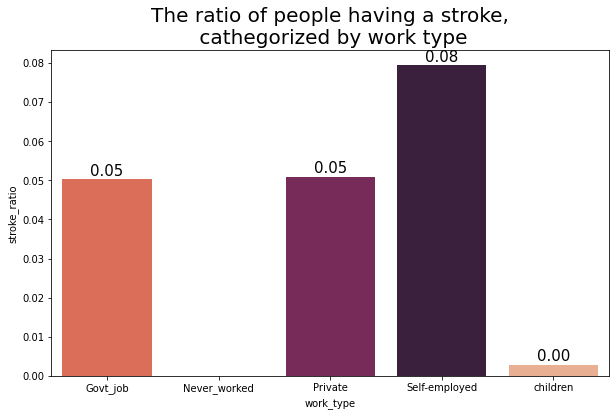

In [133]:
plot_categorical_variable_stroke_ratio(stroke_df, "work_type", "The ratio of people having a stroke,\n cathegorized by work type")

We can observe that we have very few strokes among children and never_worked (which are mostly children). The stroke events are evenly split among government jobs and private work types, but self-employed people tend to have more strokes. Accordingly to this [study](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7287446/), **self-employed people might have a higher risk of having a cardiovascular disease**, which might lead to a stroke, but the studies made about this subject are very limited.

#### Residence Type

The feature shows whether the person lives in a rural or urban area.

In [ ]:
residence_type_value_counts = stroke_df.residence_type.value_counts()
residence_type_value_counts

Urban    2596
Rural    2514
Name: residence_type, dtype: int64

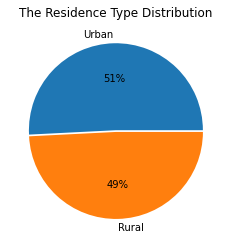

In [ ]:
explode = [0.01] * residence_type_value_counts.count()
plt.pie(residence_type_value_counts.array, labels=residence_type_value_counts.index, autopct = '%0.0f%%', explode = explode)
plt.title("The Residence Type Distribution")
plt.show()

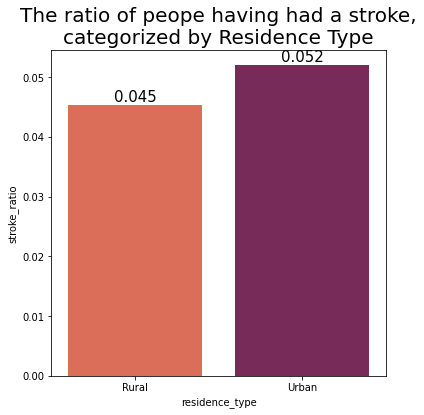

In [ ]:
plot_categorical_variable_stroke_ratio(stroke_df, "residence_type", "The ratio of peope having had a stroke,\ncategorized by Residence Type", 3)

The data shows that people living in an urban area have a slightly higher chance for a stroke (5.2% vs 4.5%), but the residence type does not seem to be a significant factor in one's chance for a stroke.

The people are fairly distributed between twose living in urban and in rural areas.

#### Average Glucose Level

This feature shows the average glucose level in a person's blood, in mg/dL.

In [ ]:
stroke_df.avg_glucose_level.describe()

count    5110.000000
mean      106.147677
std        45.283560
min        55.120000
25%        77.245000
50%        91.885000
75%       114.090000
max       271.740000
Name: avg_glucose_level, dtype: float64

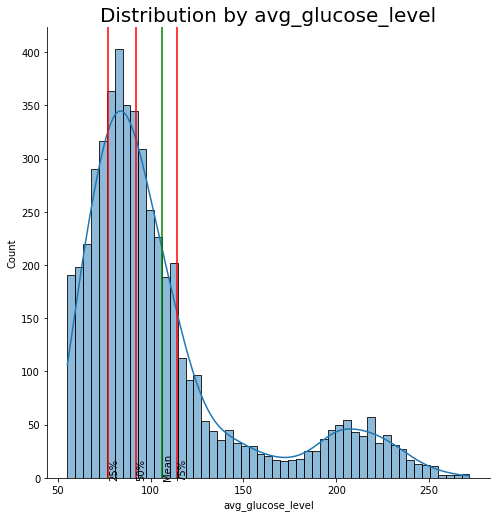

In [41]:
plot_continuous_variable_distribution(stroke_df, stroke_df.avg_glucose_level, "avg_glucose_level", "Distribution by avg_glucose_level")

Text(0.5, 1.0, 'Avg Glucose Level Distribution by Stroke Status')

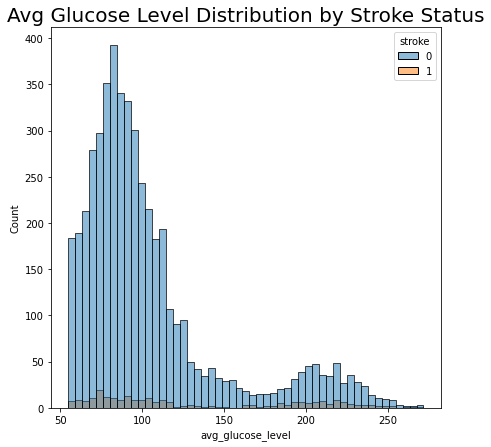

In [ ]:
fig, ax = plt.subplots(figsize=def_fig_size)
sns.histplot(data=stroke_df, x="avg_glucose_level", hue="stroke", ax=ax)
plt.title("Avg Glucose Level Distribution by Stroke Status", size = def_title_size)

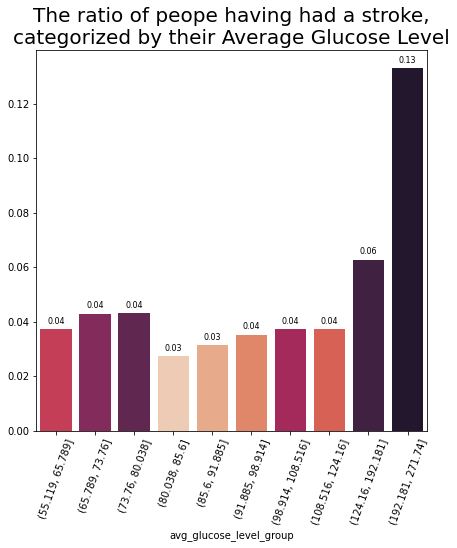

In [ ]:
plot_continuous_variable_stroke_ratio(stroke_df, "avg_glucose_level", 10, "The ratio of peope having had a stroke,\ncategorized by their Average Glucose Level", 70)

As expected, both people with a very low and with a very high blood glucose level are more likely to have a stroke than the people with a regular glucose level. 

General medical guidelines state that a glucose level of less than 100mg/dL is normal after not eating for more than 8 hours, and a glucose level of less than 140mg/dL is normal after not eating for at least 2 hours ([see this analysis](https://https://www.webmd.com/diabetes/how-sugar-affects-diabetes)). These guidelines are confirmed by the above plot, which shows that


*   an average glucose level lower than 80mg/dL may increase the chance for a stroke, by ~30%
*   an average glucose level higher than 124mg/dL may dramatically increase the chance for a stroke, by more than 200%



#### Body Mass Index

There also might be children in our dataset, we do not want to consider them for the adult BMI analysis since the way their BMI is interpreted is different than for adults.

In [59]:
adults_only_df = stroke_df.loc[stroke_df['age']>=18]
adults_only_df.bmi.describe()

count    4073.000000
mean       30.432752
std         7.235143
min        11.300000
25%        25.400000
50%        29.200000
75%        34.200000
max        92.000000
Name: bmi, dtype: float64

A BMI of: 

* less than 18.5 is Underweight
* 18.5 - 25 is Normal	
* 25 - 30 is Overweight	
* 30 - 35 is Moderate Obesity
* 35 - 40 is Severe Obesity
* 40 - 46 is Very Severe Obesity
* 45-50 is Morbid
* 50-60 is Super
* greater then 60 is Hyper Obesity 
 
Data extracted from this ([article](https://www.topdoctors.co.uk/medical-dictionary/body-mass-index-bmi)).
 
 The fact that we have a mean value of 30 means that the dataset tends to describe a population that is slightly more overweight. 

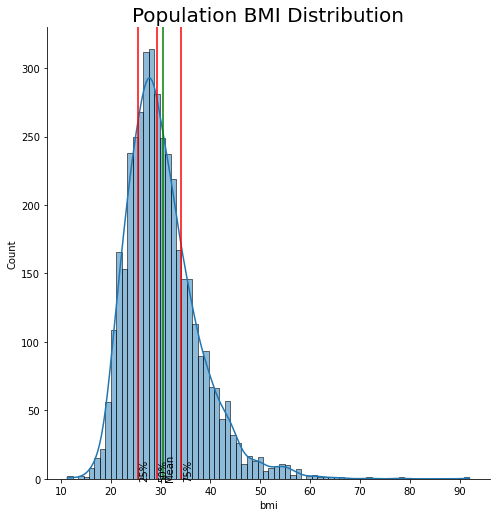

In [58]:

plot_continuous_variable_distribution(adults_only_df, adults_only_df.bmi, "bmi", "Population BMI Distribution")

The data from above might be better understood if we would classify the BMI value by what it represents i.e. underweight, normal, overweight etc.

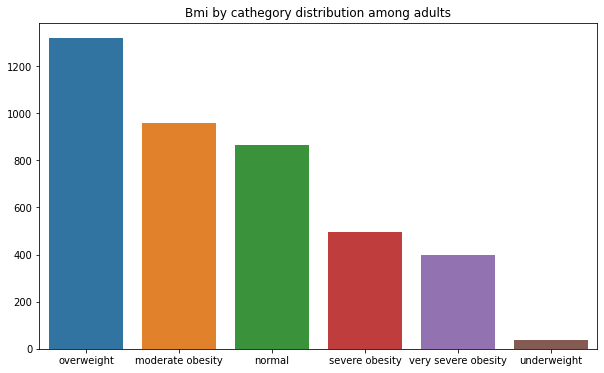

In [138]:
stroke_df_with_bmi_categ = adults_only_df.copy()
stroke_df_with_bmi_categ.bmi = adults_only_df.bmi.apply(identify_bmi_cathegory)

bmi_categ_value_counts = stroke_df_with_bmi_categ.bmi.value_counts()

plt.figure(figsize=(10,6))
plt.title("Bmi by cathegory distribution among adults")
sns.barplot(x=bmi_categ_value_counts.index, y=bmi_categ_value_counts.array)
plt.show()


The distrubution based on the BMI classifications is not very balanced, as is having more cases of overweight and obese people than people with normal weight. 

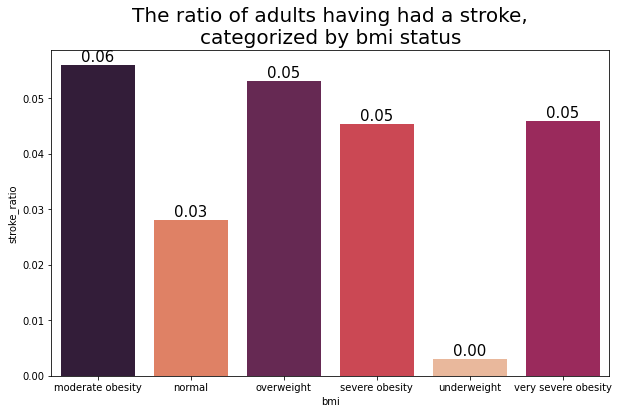

In [131]:

plot_categorical_variable_stroke_ratio(stroke_df_with_bmi_categ, "bmi", 
                                       "The ratio of adults having had a stroke,\ncategorized by bmi status")

As expected, the adults with obesity are more likely to have a stroke.

Now let's analyze how the BMI values for children.
 

In [140]:
children_only_df = stroke_df.loc[stroke_df['age']<18]
children_only_df.bmi.describe()



count    836.000000
mean      21.392703
std        6.278310
min       10.300000
25%       17.600000
50%       19.900000
75%       23.500000
max       97.600000
Name: bmi, dtype: float64

We can observe that the mean value for children is 21, which is less than the one for adults, as we should expect.

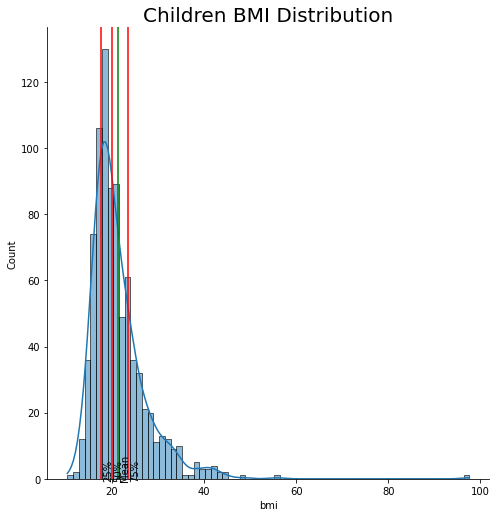

In [141]:
plot_continuous_variable_distribution(children_only_df, children_only_df.bmi, "bmi", "Children BMI Distribution")

As expected, the whole distribution of bmi for children lays to the left, having in general smaller values for bmi than the values that we have for adults.

#### Smoking Status

This feature shows whether a person


*   smokes
*   formerly smoked
*   never smoked
*   their smoking status is unknown



In [80]:
smoking_value_counts = stroke_df.smoking_status.value_counts()
smoking_value_counts

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

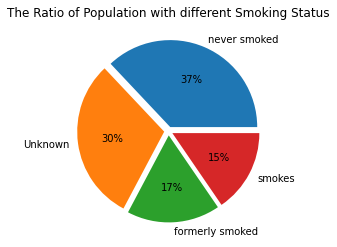

In [81]:
explode = [0.05] * smoking_value_counts.count()
plt.pie(smoking_value_counts.array, labels=smoking_value_counts.index, autopct = '%0.0f%%', explode = explode)
plt.title("The Ratio of Population with different Smoking Status")
plt.show()

We can see that 30% of the data is missing. We can't drop 30% of the data, so we should replace the 'Unknown' values somehow.

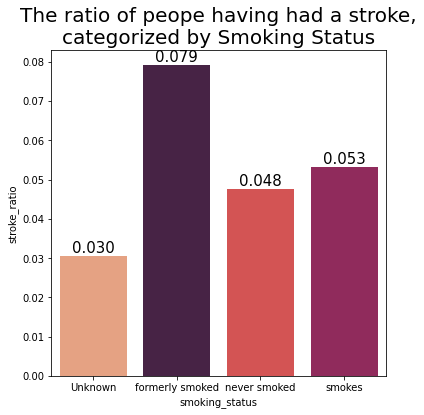

In [82]:
plot_categorical_variable_stroke_ratio(stroke_df, "smoking_status", "The ratio of peope having had a stroke,\ncategorized by Smoking Status", 3)

Unexpectedly, the ratio of people who had a stroke is higher among former smokers than among current smokers. 

This may be explained by the facts that:


*   those who have formerly smoked may be older
*   many of those who are smoking now may have smoked for less time




### The label: Stroke

The most imporant part is knowing the number of people that had stroke in our dataset, since this is what we are trying to predict.

In [143]:
stroke_value_counts = stroke_df.stroke.value_counts()
stroke_value_counts

0    4861
1     249
Name: stroke, dtype: int64

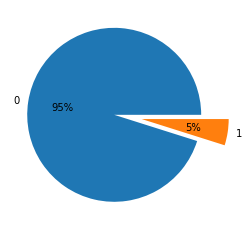

In [144]:
explode = [0.02,0.3]
plt.pie(stroke_value_counts.array, labels=stroke_value_counts.index, autopct = '%0.0f%%', explode = explode)
plt.show()

Only 5% of people in our dataset have had a stroke. 

## Data Cleaning

### Work Type

### Body Mass Index

### Smoking Status

## Random code

TODO: delete this section

In [ ]:
stroke_df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [ ]:
stroke_df.work_type.value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [ ]:
stroke_df.age.map(lambda a: 1 if a >= 16 else 0).value_counts()

1    4366
0     744
Name: age, dtype: int64

In [ ]:
stroke_df[stroke_df["age"]<16][stroke_df["work_type"]!="children"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
251,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,Unknown,0
253,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,Unknown,0
284,26325,Male,14.0,0,0,No,Govt_job,Urban,82.34,31.6,Unknown,0
410,54975,Male,7.0,0,0,No,Self-employed,Rural,64.06,18.9,Unknown,0
455,7351,Male,13.0,0,0,No,Private,Urban,92.14,23.2,never smoked,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4709,41930,Male,15.0,0,0,No,Private,Rural,144.15,24.1,never smoked,0
4806,69723,Male,15.0,0,0,No,Private,Urban,137.27,19.3,never smoked,0
4903,56629,Female,14.0,0,0,No,Private,Rural,83.56,33.1,Unknown,0
4923,72186,Female,15.0,0,0,No,Private,Rural,82.19,40.5,never smoked,0
